In [4]:
import rasterio
import geopandas as gpd
from rasterio.features import shapes
from shapely.geometry import shape
import xarray as xr
import numpy as np
import pandas as pd

# อ่านข้อมูลจากไฟล์ GeoTIFF (.tif)
tif_path = "../csv-file/temp_raster.tif"  # เส้นทางของไฟล์ .tif
with rasterio.open(tif_path) as src:
    # อ่านข้อมูล raster (band) เป็น array
    image = src.read(1)  # อ่านแค่แบนด์แรก (กรณีมีแค่ 1 band)
    
    # สร้าง shape จากข้อมูล raster ที่อ่านมา
    # `shapes` จะส่งกลับ list ของ dicts ที่มี 'properties' และ 'geometry'
    results = (
        {'properties': {'value': v}, 'geometry': shape(s)}
        for s, v in shapes(image, transform=src.transform)
    )

# อ่านข้อมูลจาก NetCDF (ไฟล์ที่มีตัวแปร 'tmp')
nc_path = "../dataset-nc/cru_ts4.08.1901.2023.tmp.dat.nc"  # เส้นทางของไฟล์ NetCDF
ds = xr.open_dataset(nc_path)
tmp_data = ds['tmp']  # ตัวแปร tmp

# ตรวจสอบข้อมูลใน 'time'
print(ds['time'])

# กำหนดปีที่เราต้องการ เช่น ปี 2000
target_date = pd.to_datetime('2000-01-01')

# สร้างคอลัมน์ที่จะเก็บค่าจากตัวแปร 'tmp'
for result in results:
    # แปลงพิกัด geometry (จากรูปทรงใน GeoTIFF) เป็นพิกัดที่สามารถใช้เทียบกับข้อมูลใน NetCDF
    geom = result['geometry']
    # คำนวณพิกัดศูนย์กลางของแต่ละ shape (ใช้ centroid เพื่อหาพิกัด)
    centroid = geom.centroid
    lat = centroid.y
    lon = centroid.x

    # เช็คว่าพิกัดตรงกับข้อมูลใน NetCDF หรือไม่
    # หากมีข้อมูลในระยะที่กำหนด ก็จะนำค่าจาก tmp มาใส่ใน 'properties'
    # ตัวอย่างเช่น ให้แปลง lat, lon เป็น index สำหรับดึงข้อมูลจาก tmp
    lat_idx = np.abs(ds['lat'] - lat).argmin()  # หาค่าดัชนีที่ใกล้ที่สุดของ lat
    lon_idx = np.abs(ds['lon'] - lon).argmin()  # หาค่าดัชนีที่ใกล้ที่สุดของ lon
    
    # ใช้ method='nearest' เพื่อเลือกค่าที่ใกล้เคียงที่สุดใน time (กรณีวันที่ไม่ได้ตรงกัน)
    tmp_value = tmp_data.sel(lat=lat_idx, lon=lon_idx, time=target_date, method='nearest').values

    # เช็คว่า tmp_value เป็น scalar หรือไม่
    if np.ndim(tmp_value) > 0:
        result['properties']['tmp'] = tmp_value[0]  # tmp_value อาจจะเป็น array, ต้องเลือกค่าตัวแรก
    else:
        result['properties']['tmp'] = tmp_value  # ถ้าเป็น scalar ให้ใช้ค่า tmp_value ตรงๆ

# แปลงข้อมูลเป็น GeoDataFrame
gdf = gpd.GeoDataFrame.from_features(results)

# บันทึกข้อมูลเป็น GeoJSON
gdf.to_file("../Geo-data/output_data_geo.json", driver="GeoJSON")





<xarray.DataArray 'time' (time: 1476)> Size: 12kB
array(['1901-01-16T00:00:00.000000000', '1901-02-15T00:00:00.000000000',
       '1901-03-16T00:00:00.000000000', ..., '2023-10-16T00:00:00.000000000',
       '2023-11-16T00:00:00.000000000', '2023-12-16T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 12kB 1901-01-16 1901-02-15 ... 2023-12-16
Attributes:
    long_name:  time


KeyboardInterrupt: 

In [ ]:
import xarray as xr
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np

# อ่านข้อมูลจาก NetCDF
nc_path = "../dataset-nc/cru_ts4.08.1901.2023.tmp.dat.nc"  # เส้นทางของไฟล์ NetCDF
ds = xr.open_dataset(nc_path)

# แปลง time เป็น datetime และกรองข้อมูลเฉพาะปี 2000
ds['time'] = pd.to_datetime(ds['time'].values)

# กำหนดวันที่ที่ต้องการ (เช่น ปี 2000)
target_date = pd.to_datetime('2000-01-01')

# ใช้ method='nearest' เพื่อเลือกค่าที่ใกล้เคียงที่สุดใน time
tmp_data_2000 = ds['tmp'].sel(time=target_date, method='nearest')

# แปลงข้อมูล 'lat', 'lon' เป็น meshgrid เพื่อเข้าถึงค่าของ 'tmp' สำหรับแต่ละพิกัด
lon, lat = np.meshgrid(ds['lon'], ds['lat'])

# เตรียมข้อมูลสำหรับการสร้าง GeoDataFrame
features = []

# ทำการสร้าง features สำหรับแต่ละ grid
for i in range(len(ds['lat'])):
    for j in range(len(ds['lon'])):
        # ดึงค่าของ tmp จากตำแหน่งนั้น ๆ
        tmp_value = tmp_data_2000.isel(lat=i, lon=j).values.item()  # ใช้ item() เพื่อดึงค่าจาก array 0 มิติ
        
        # สร้าง geometry จากพิกัด (longitude, latitude)
        point = Point(lon[0, j], lat[i, 0])  # ใช้แค่พิกัดของตำแหน่งนั้น ๆ
        
        # เพิ่มข้อมูลเข้าไปใน features
        features.append({
            'geometry': point,
            'properties': {'tmp': tmp_value, 'lat': lat[i, 0], 'lon': lon[0, j]}
        })

# สร้าง GeoDataFrame จาก features ที่เตรียมไว้
gdf = gpd.GeoDataFrame.from_features(features)

# บันทึกเป็น GeoJSON
gdf.to_file("../Geo-data/output_tmp_2000.json", driver="GeoJSON")





C:\Users\supakron\AppData\Roaming\Python\Python312\site-packages\pyogrio\raw.py:698: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  warnings.warn(


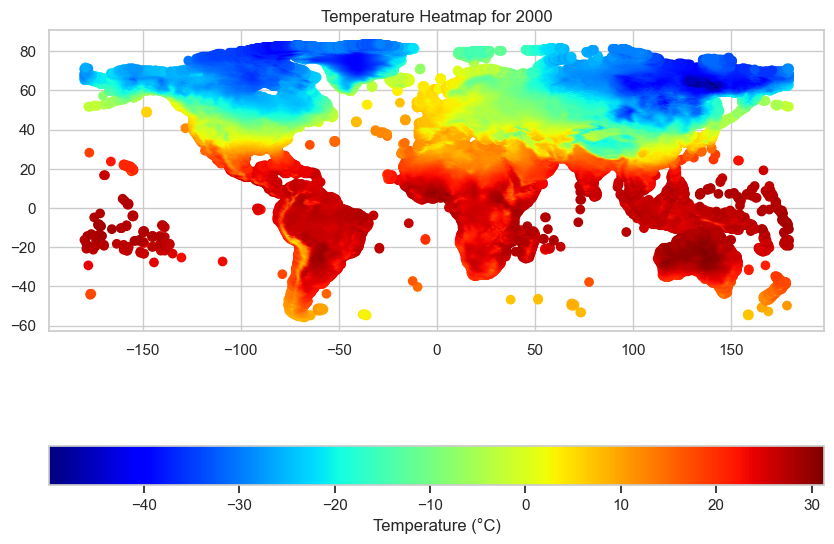

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

# อ่านไฟล์ GeoJSON
gdf = gpd.read_file('../Geo-data/output_tmp_2000.json')

# ตั้งค่ารูปแบบการแสดงผลสี
sns.set(style="whitegrid")

# สร้าง plot โดยใช้ geopandas
fig, ax = plt.subplots(figsize=(10, 10))

# ใช้สีตามค่า 'tmp' โดยจะเลือก color map เช่น "viridis", "coolwarm", "inferno"
gdf.plot(column='tmp', ax=ax, legend=True, cmap='jet', 
         legend_kwds={'label': "Temperature (°C)", 'orientation': "horizontal"})

# แสดง plot
plt.title('Temperature Heatmap for 2000')
plt.show()


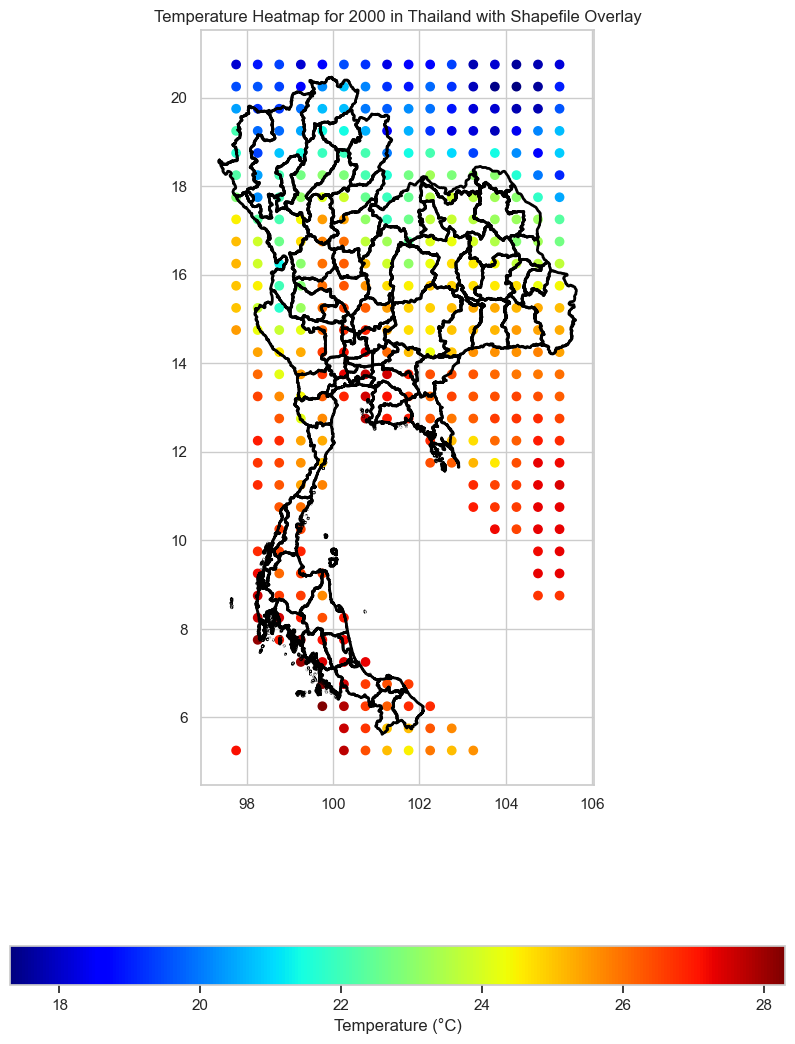

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

# อ่านไฟล์ GeoJSON (ข้อมูล tmp)
gdf_tmp = gpd.read_file('../Geo-data/output_tmp_2000.json')

# อ่านไฟล์ Shapefile (ข้อมูลขอบเขตของประเทศไทย)
gdf_shapefile = gpd.read_file('../Geo-data/shapefile-lv1-thailand.json')  # ปรับ path ให้ตรงกับไฟล์ Shapefile ของคุณ

# กรองข้อมูล GeoDataFrame สำหรับประเทศไทย (ใช้พิกัดที่เหมาะสม)
# พิกัดของประเทศไทย (longitude: 97.5 - 105.5, latitude: 5 - 21)
gdf_tmp_thailand = gdf_tmp.cx[97.5:105.5, 5:21]
gdf_shapefile_thailand = gdf_shapefile.cx[97.5:106.5, 5:21]

# ตั้งค่ารูปแบบการแสดงผลสี
sns.set(style="whitegrid")

# สร้าง plot โดยใช้ geopandas
fig, ax = plt.subplots(figsize=(10, 14))

# Plot Shapefile (ขอบเขตของประเทศไทย)
gdf_shapefile_thailand.boundary.plot(ax=ax, edgecolor='black', linewidth=2)

# Plot GeoJSON (ข้อมูล tmp) โดยใช้สีตามค่า 'tmp'
gdf_tmp_thailand.plot(column='tmp', ax=ax, legend=True, cmap='jet', 
                     legend_kwds={'label': "Temperature (°C)", 'orientation': "horizontal"})

# แสดง plot
plt.title('Temperature Heatmap for 2000 in Thailand with Shapefile Overlay')
plt.show()



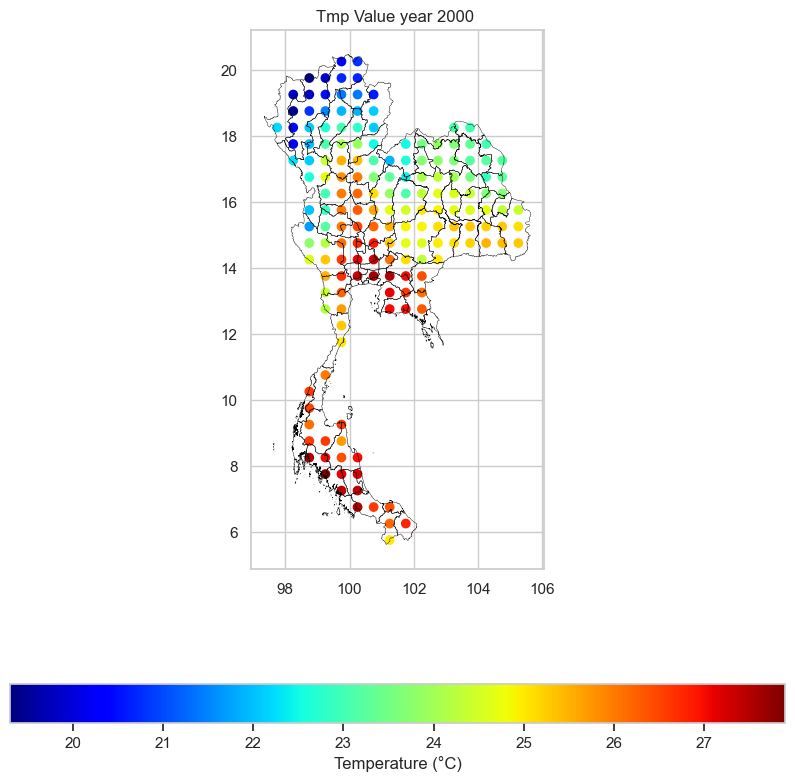

In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

# อ่านไฟล์ GeoJSON (ข้อมูล tmp)
gdf_tmp = gpd.read_file('../Geo-data/output_tmp_2000.json')

# อ่านไฟล์ Shapefile (ข้อมูลขอบเขตของประเทศไทย)
gdf_shapefile = gpd.read_file('../Geo-data/shapefile-lv1-thailand.json')  # ปรับ path ให้ตรงกับไฟล์ Shapefile ของคุณ

# กรองข้อมูล GeoDataFrame สำหรับประเทศไทย (ใช้พิกัดที่เหมาะสม)
# พิกัดของประเทศไทย (longitude: 97.5 - 105.5, latitude: 5 - 21)
gdf_tmp_thailand = gdf_tmp.cx[97.5:105.5, 5:21]
gdf_shapefile_thailand = gdf_shapefile.cx[97.5:105.5, 5:21]

# ใช้ฟังก์ชัน clip เพื่อคลิปข้อมูลใน gdf_tmp ให้อยู่ภายในขอบเขตของประเทศไทย
gdf_tmp_clipped = gdf_tmp_thailand.clip(gdf_shapefile_thailand)

# ตั้งค่ารูปแบบการแสดงผลสี
sns.set(style="whitegrid")

# สร้าง plot โดยใช้ geopandas
fig, ax = plt.subplots(figsize=(10, 10))

# Plot Shapefile (ขอบเขตของประเทศไทย)
gdf_shapefile_thailand.boundary.plot(ax=ax, edgecolor='black', linewidth=0.3)

# Plot GeoJSON (ข้อมูล tmp) โดยใช้สีตามค่า 'tmp'
gdf_tmp_clipped.plot(column='tmp', ax=ax, legend=True, cmap='jet', 
                     legend_kwds={'label': "Temperature (°C)", 'orientation': "horizontal"})

# แสดง plot
plt.title('Tmp Value year 2000 ')
plt.show()
